In [1]:
import glob
import numpy as np
import tensorflow as tf

# Load File Names

In [2]:
dataset_dir = 'ISIC2018_Task1-2_Training_Data/'
input_dir = dataset_dir + 'ISIC2018_Task1-2_Training_Input_x2/' # directory of original images
groundtruth_dir = dataset_dir + 'ISIC2018_Task1_Training_GroundTruth_x2/' # direstory of groundtruth images

input_filenames = glob.glob(input_dir + '/*.jpg')
input_filenames = sorted(input_filenames)

groundtruth_filenames = glob.glob(groundtruth_dir + '/*.png')
groundtruth_filenames = sorted(groundtruth_filenames)

In [3]:
# sanity check
import random

assert len(input_filenames) == len(groundtruth_filenames), "the number of input files does not equal to the number of groundtruth files" # 2594

random_index = random.randint(0, len(input_filenames))
random_input, random_gtruth = input_filenames[random_index], groundtruth_filenames[random_index]
input_number_index, gtruth_number_index = random_input.index("ISIC_") + len("ISIC_"), random_gtruth.index("ISIC_") + len("ISIC_")
assert random_input[input_number_index:input_number_index+7] == random_gtruth[gtruth_number_index:gtruth_number_index+7], "the serial number of input file and groundtruth file does not match"

# train/val/test Split

In [4]:
# split the dataset into train/val/test set, the ratio is 8:1:1 by default

def train_val_test_split(inputs, groundtruths, split_rate=.1):
    if inputs.__class__.__name__ == 'list':
        inputs = np.array(inputs)
    if groundtruths.__class__.__name__ == 'list':
        groundtruths = np.array(groundtruths)
    test_size = int(len(inputs) * split_rate)

    indices = np.random.permutation(len(inputs))
    train_idx, val_idx, test_idx = indices[2*test_size:], indices[test_size:2*test_size], indices[:test_size]

    train_images, train_labels = inputs[train_idx], groundtruths[train_idx]
    val_images, val_labels = inputs[val_idx], groundtruths[val_idx]
    test_images, test_labels = inputs[test_idx], groundtruths[test_idx]

    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

    return train_ds, val_ds, test_ds

# input_filenames = input_filenames[:1000] #
# groundtruth_filenames = groundtruth_filenames[:1000] #

train_ds, val_ds, test_ds = train_val_test_split(input_filenames, groundtruth_filenames)

# Read Images & Pre-process Data

In [5]:
def map_fn(image_filename, label_filename):
    # input image
    img = tf.io.read_file(image_filename)
    img = tf.io.decode_jpeg(img, channels=3) # RGB image
    img = tf.image.resize(img, (256, 256))
    img = img / 255.

    # ground truth image
    label = tf.io.read_file(label_filename)
    label = tf.io.decode_jpeg(label, channels=1) # greyscale image
    label = tf.image.resize(label, (256, 256))
    label = label / 255.
    label = tf.cast(label > 0.5, dtype=tf.float32)

    return img, label

train_ds = train_ds.map(map_fn)
val_ds = val_ds.map(map_fn)
test_ds = test_ds.map(map_fn)

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

# Visualization

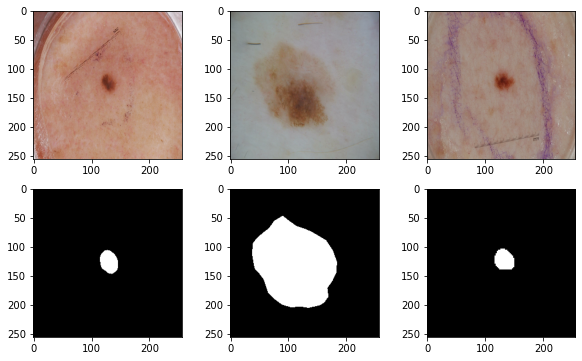

In [6]:
import matplotlib.pyplot as plt

for input_img, gtruth_img in val_ds.take(1):
    fig = plt.figure(figsize=(10, 6))
    rows, columns = 2, 3

    for i in range(3):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(input_img.numpy()[i])

        fig.add_subplot(rows, columns, i+1+columns)
        plt.imshow(gtruth_img.numpy()[i], cmap='gray')

    plt.show()


# Improved U-Net

In [7]:
# !pip install tensorflow_addons
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

from tensorflow_addons.layers import InstanceNormalization


def context_module(pre_layer, n_filters, leaky_slope=1e-2, dropout_rate=0.3):

    # 1st
    norm1 = InstanceNormalization()(pre_layer)
    leakyRelu1 = LeakyReLU(alpha=leaky_slope)(norm1)
    conv1 = Conv2D(filters=n_filters, kernel_size=3, strides=1, padding='same', use_bias=False)(leakyRelu1)

    dropout = Dropout(dropout_rate)(conv1)

    # 2nd
    norm2 = InstanceNormalization()(dropout)
    leakyRelu2 = LeakyReLU(alpha=leaky_slope)(norm2)
    conv2 = Conv2D(filters=n_filters, kernel_size=3, strides=1, padding='same', use_bias=False)(leakyRelu2)

    return conv2


def localization_module(pre_layer, n_filters, leaky_slope=1e-2):

    conv1 = Conv2D(filters=n_filters, kernel_size=3, strides=1, padding='same', 
                    activation=LeakyReLU(leaky_slope))(pre_layer)
    norm1 = InstanceNormalization()(conv1)

    conv2 = Conv2D(filters=n_filters/2, kernel_size=1, strides=1, padding='same',
                    activation=LeakyReLU(leaky_slope))(norm1)
    norm2 = InstanceNormalization()(conv2)

    return norm1, norm2

def improved_UNet(input_shape=(256, 256, 3), n_filters=16, n_classes=1, dropout_rate=0.3, leaky_slope=1e-2):
    
    input_layer = Input(shape=input_shape)

    # context pathway 1 (top)
    con1_conv = Conv2D(n_filters*1, kernel_size=3, strides=1, padding='same')(input_layer)
    con1_context = context_module(con1_conv, n_filters*1, leaky_slope, dropout_rate)
    con1_context += con1_conv
    
    # context pathway 2
    con2_conv = Conv2D(n_filters*2, kernel_size=3, strides=2, padding='same')(con1_context)
    con2_context = context_module(con2_conv, n_filters*2, leaky_slope, dropout_rate)
    con2_context += con2_conv

    # context pathway 3 
    con3_conv = Conv2D(n_filters*4, kernel_size=3, strides=2, padding='same')(con2_context)
    con3_context = context_module(con3_conv, n_filters*4, leaky_slope, dropout_rate)
    con3_context += con3_conv

    # context pathway 4
    con4_conv = Conv2D(n_filters*8, kernel_size=3, strides=2, padding='same')(con3_context)
    con4_context = context_module(con4_conv, n_filters*8, leaky_slope, dropout_rate)
    con4_context += con4_conv

    # context pathway 5 (bottom)
    con5_conv = Conv2D(n_filters*16, kernel_size=3, strides=2, padding='same')(con4_context)
    con5_context = context_module(con5_conv, n_filters*16, leaky_slope, dropout_rate)
    con5_context += con5_conv

    # localization pathway 1 (bottom)
    local1_up = UpSampling2D()(con5_context)
    local1_conv = Conv2D(n_filters*8, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local1_up) # TODO: use_bias=False

    # localization pathway 2
    local2_concat = concatenate([local1_conv, con4_context])
    _, local2_localization = localization_module(local2_concat, n_filters*8, leaky_slope)
    local2_up = UpSampling2D()(local2_localization)
    local2_conv = Conv2D(n_filters*4, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local2_up) # TODO: use_bias=False
    
    # localization pathway 3
    local3_concat = concatenate([local2_conv, con3_context])
    tmp_1, local3_localization = localization_module(local3_concat, n_filters*4, leaky_slope)
    local3_up = UpSampling2D()(local3_localization)
    local3_conv = Conv2D(n_filters*2, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local3_up) # TODO: use_bias=False
    
    # localization pathway 4
    local4_concat = concatenate([local3_conv, con2_context])
    tmp_2, local4_localization = localization_module(local4_concat, n_filters*2, leaky_slope)
    local4_up = UpSampling2D()(local4_localization)
    local4_conv = Conv2D(n_filters*1, kernel_size=3, strides=1, padding='same', 
                         activation=LeakyReLU(leaky_slope))(local4_up)
    
    # final (top)
    final_concat = concatenate([local4_conv, con1_context])
    final_conv = Conv2D(n_filters*2, kernel_size=3, strides=1, padding='same', 
                        activation=LeakyReLU(leaky_slope))(final_concat)

    # segmentations
    seg_1 = Conv2D(n_classes, kernel_size=1, strides=1)(tmp_1)
    seg_1_up = UpSampling2D(interpolation='bilinear')(seg_1)

    seg_2 = Conv2D(n_classes, kernel_size=1, strides=1)(tmp_2)
    seg_2_up = UpSampling2D(interpolation='bilinear')(seg_2+seg_1_up)

    seg_3 = Conv2D(n_classes, kernel_size=1, strides=1)(final_conv)
    final_add = seg_2_up + seg_3

    # sigmoid
    pre = Activation('sigmoid')(final_add)

    return Model(inputs = input_layer, outputs = pre)

model = improved_UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 16) 0           instance_normalization[0][0]     
______________________________________________________________________________________________

In [8]:
def dice_coef(y_true, y_pred, smooth=1e-5):
    intersection = tf.reduce_sum(y_pred * y_true)
    X = tf.reduce_sum(y_pred)
    Y = tf.reduce_sum(y_true)

    dice = (2. * intersection + smooth) / (X + Y + smooth)
    return dice

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef, 'accuracy'])

In [9]:
history = model.fit(x=train_ds, epochs=5, validation_data=val_ds, shuffle=True)

Epoch 1/5
65/65 [==============================] - 380s 6s/step - loss: 0.2518 - dice_coef: 0.7482 - accuracy: 0.8852 - val_loss: 0.2030 - val_dice_coef: 0.8010 - val_accuracy: 0.9027
Epoch 2/5
65/65 [==============================] - 358s 5s/step - loss: 0.1689 - dice_coef: 0.8311 - accuracy: 0.9315 - val_loss: 0.1703 - val_dice_coef: 0.8353 - val_accuracy: 0.9168
Epoch 3/5
65/65 [==============================] - 375s 6s/step - loss: 0.1487 - dice_coef: 0.8512 - accuracy: 0.9398 - val_loss: 0.1510 - val_dice_coef: 0.8569 - val_accuracy: 0.9293
Epoch 4/5
65/65 [==============================] - 371s 6s/step - loss: 0.1380 - dice_coef: 0.8620 - accuracy: 0.9441 - val_loss: 0.1723 - val_dice_coef: 0.8283 - val_accuracy: 0.9121
Epoch 5/5
65/65 [==============================] - 383s 6s/step - loss: 0.1381 - dice_coef: 0.8619 - accuracy: 0.9438 - val_loss: 0.1596 - val_dice_coef: 0.8413 - val_accuracy: 0.9205


# Test Report and Visualization

In [10]:
first = True
for test_input, test_true in test_ds:
    test_predict = model.predict(test_input)
    test_predict = np.where(test_predict < 0.5, 0, 1)
    test_predict = test_predict[:, :, :, 0]
    test_true = test_true.numpy()[:, :, :, 0]

    if first:
        first = False
        test_predict_lst = test_predict
        test_true_lst = test_true
    else:
        test_predict_lst = np.append(test_predict_lst, test_predict, axis=0)
        test_true_lst = np.append(test_true_lst, test_true, axis=0)

test_predict_lst.shape, test_true_lst.shape

((259, 256, 256), (259, 256, 256))

In [12]:
# skin lesion
test_predict = tf.convert_to_tensor(test_predict_lst, dtype=tf.float32)
test_true = tf.convert_to_tensor(test_true_lst, dtype=tf.float32)

dice_coef(test_true, test_predict).numpy()

0.8451821

In [13]:
# background
test_predict = np.where(test_predict_lst > 0.5, 0, 1)
test_predict = tf.convert_to_tensor(test_predict, dtype=tf.float32)

test_true = np.where(test_true_lst > 0.5, 0, 1)
test_true = tf.convert_to_tensor(test_true, dtype=tf.float32)

dice_coef(test_true, test_predict).numpy()

0.9513603

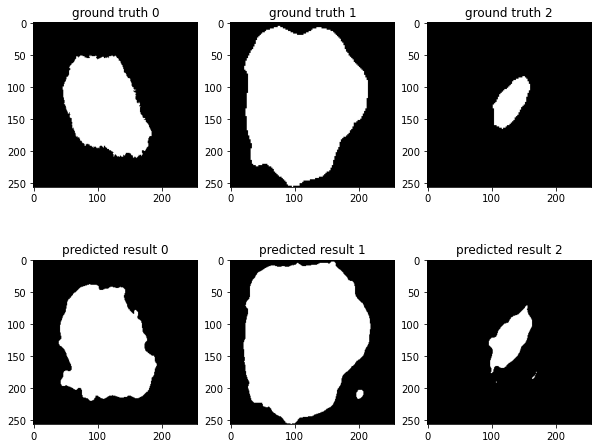

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
rows, columns = 2, 3

for i in range(3):
    gtruth_img = test_true_lst[i]
    predicted_img = test_predict_lst[i]
    
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(gtruth_img, cmap='gray')
    plt.title('ground truth {}'.format(i))

    fig.add_subplot(rows, columns, i+1+columns)
    plt.imshow(predicted_img, cmap='gray')
    plt.title('predicted result {}'.format(i))

plt.show()